In [58]:
from __future__ import print_function
import numpy as np
import scipy as sp
import scipy.ndimage
from astropy.io import fits
import sys
import numpy.ma as ma
import math
import pidly
import os
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
print("foo {8}")

foo {8}


In [18]:

"""
vlt_reduce_module.py:  
Usage: From within directory with science-only frames of a single exposure time: 
        python vlt_reduce_module.py objname
Arguments: sys.argv[1] = object name 
           sys.argv[2] = type of flat (1 if lamp, 0 if sky)
           sys.argv[3] = flag for saturated data (1 if saturated, 0 if unsaturated)
           sys.argv[4] = flag for alignment (1 if equal mass binary, 0 if single star or faint companion)     
           sys.argv[5] = flag for SHORT or LONG exposures
History:
(v1) 2018-06-01 - KWD: Updated from original script (vlt_reduce_new) to implement the following:
                        * Python 3 compatibility
                        * astropy updates (from original pyfits)
                        * modularization
                        * separation of individual frames from datacubes  
(v2) 2018-07-03 - KWD: Now usable with command line interface.
Example usage: 
python vlt_reduce_module.py 'HIP100_SHORT' 1 0 0 'SHORT'
    - would perform a reduction with lamp flats, unsaturated exposures, and no need for alignment
"""






##############  Begin Function Definitions ##############


def dark_combine(path_to_raw_darks, sci_exptime, imsize, objname):
    '''
    dark_combine
    ----------
    Routine to find corresponding darks to the science exposure times and median stack them. 
    Requires defined path for raw dark frames.
        
    Inputs
    ----------
    path_to_raw_darks   : (string) path to location of dark directory for given target; usu. './DARK/'
    sci_exptime         : (float) exposure time of the science files to be calibrated
    imsize              : (int) dimension of FITS image array
    objname             : (string) name of target directory
    
    Returns
    ----------
    med_dark            : (array) median-combined dark frame
    
    darkname            : (FITS file) output fits file of master dark frame and header taken from first raw dark.
    Dependents
    ----------
    sci_exptime         : (float)
    
    History
    ----------
    (v1) 2018-06-19 - KWD: Updated from original script for Python 3 compatibility and astropy updates.
    (v2) 2018-06-20 - SGC: Added objname parameter.
    (v3) 2018-06-22 - KWD: Updated input variables for compatibility with process_flats function.
    '''
    darklist = glob.glob(path_to_raw_darks + '*fits')
    n = len(darklist)

    im = fits.open(darklist[0], ignore_missing_end=True)
    darkheader = im[0].header

    date = darkheader['UTSTART']
    date = date[0:10]


    # Make a new list of darks that match the provided exptime:
    matching_darks = []

    # Select only those darks that match the given exposure time:
    for each_dark in darklist:
        header = fits.getheader(each_dark)
        if header['EXPTIME'] == sci_exptime:
            matching_darks.append(each_dark)
        else:
            pass

    number_of_darks = len(matching_darks)

    print('Found {number_of_darks} darks with exposure times of {sci_exptime}. \n')

    if number_of_darks == 0:
        raise ValueError('There are no matching dark frames.')

    darkarray = np.zeros([imsize, imsize, number_of_darks])

    for ii in range(0, number_of_darks):
        header = fits.getheader(matching_darks[ii])

        # check to add only those those darks with correct exptime
        if header['EXPTIME'] == sci_exptime:
            im = fits.getdata(matching_darks[ii]) 
            if len(im.shape) == 3: # check for data cubes
                assert not np.any(np.isnan(im))
                im = np.median(im, axis=0) # if data cube, then median frames
            darkarray[:,:,ii] = im

    med_dark = np.median(darkarray, axis=2)
    darkname = objname + '_' + date + '_masterdark_' + str(sci_exptime) + 's.fits'
    fits.writeto(darkname, med_dark, darkheader, overwrite=True, output_verify='silentfix')
    return med_dark




def process_flats(path_to_raw_flats, path_to_raw_darks, imsize, flatcategory, objname):
    '''
    process_flats
    ----------
    Routine to combine individual flat frames into a master flat. Depending on type of flat, 
    will: (0 - SKY) find corresponding darks to the flat exposure times, median stack the darks, and 
    subtract the master dark from each flatfield, then stack the flats into a master flat.
    Or, will (1 - LAMP) determine which of the flats are "on" and "off" and combine each of the on 
    and off sequences into a master "on" and master "off", then subtract them.
        
    Inputs
    ----------
    path_to_raw_flats       : (string) path to location of flatfield directory for given target; usu. './FLAT/'
    path_to_raw_darks       : (string) path to location of dark directory for given target; usu. './DARK/'
    imsize                  : (int) dimension of FITS image array
    flatcategory            : (boolean) describe whether flats are lamps (1) or sky/twilight (0)
    objname                 : (string) name of target, e.g., "HIP123"
        
    Returns
    ----------
    med_flat                : (array) median-combined flat frame
    master_flat             : (array) normalized, combined flatframe
    flatname                : (FITS file) output fits file of median flatfield (can be lamp or sky)
    masterflatname          : (FITS file) output fits file of master flatfield
    Dependents
    ----------
    flat_exptime            : (float)
    dark_combine            : (function)
    '''

    flatlist = glob.glob(path_to_raw_flats + '*fits')
    n = len(flatlist)

    flatheader = fits.getheader(flatlist[0], ignore_missing_end=True)

    date = flatheader['UTSTART']
    date = date[0:10]
    

    # if flats are lamp flats:
    if flatcategory == 1:

        # check exposure times: lamp flats should all be the same
        flattimes = [fits.getheader(im)['EXPTIME'] for im in flatlist]
        if all(x == flattimes[0] for x in flattimes):
            print("Flatfield exposure time: " + str(flattimes[0]) + "\n")
        else:
            raise Exception("Exposure times for given list of lamp flats do not match.")


        flatarray = np.zeros([imsize, imsize, n])

        for ii in range(0,n):
            flatdata = fits.getdata(flatlist[ii], ignore_missing_end=True)
            if len(flatdata.shape) == 3: #check for data cubes
                assert not np.any(np.isnan(flatdata))
                flatdata = np.median(flatdata, axis=0) #if data cube, then median frames
            flatarray[:,:,ii] = flatdata

        tmp_medval = np.average(flatarray)
        flaton = np.zeros([imsize,imsize,n])
        flatoff = np.zeros([imsize,imsize,n])

        counton = 0
        countoff = 0    

        for ii in range(0, n):
            if np.median(flatarray[:,:,ii]) < tmp_medval:
                flatoff[:,:,countoff] = flatarray[:,:,ii]
                countoff += 1
            else:
                flaton[:,:,counton] = flatarray[:,:,ii]
                counton += 1
        
        medflatoff = np.median(flatoff, axis = 2)
        medflaton = np.median(flaton,axis = 2)    
        med_flat = medflaton - medflatoff
        flatname = objname + '_' + date + '_medianlampflat.fits'
        fits.writeto(flatname, med_flat, flatheader, overwrite = True, output_verify='silentfix')     
        
        # some housekeeping to free up memory (at some point)
        del flatarray
        del flaton
        del flatoff        



    # if flats are twilight/skyflats:
    elif flatcategory == 0:
        
        # determine if a master dark with appropriate exposure time exists in main directory:
        exptime = flatheader['EXPTIME']
        masterdark = glob.glob('*masterdark*'+str(exptime)+'*fits')
        
        flatarray = np.zeros([imsize, imsize, n])
        
        if len(masterdark) == 0:
            print('Creating new master dark for flats with '+str(exptime)+'s exposure. \n')
            med_dark = dark_combine(path_to_raw_darks, exptime, imsize, objname)

        elif len(masterdark) > 1:
            print('Error: Too many matching darks for given exptime.')

        else:
            med_dark = fits.getdata(masterdark[0])

        # subtract off the median dark frame from each of the twiflats, IF median dark is the same exposure length as the twilight flats. 
        for i in range (0,n):
            flatarray[:,:,i] -= med_dark
        
        median_flat1 = np.median(flatarray[:,:,0])
        
        for i in range(0,n):
            flatmedian = np.median(flatarray[:,:,i])
            flatarray[:,:,i] *= (median_flat1/flatmedian)

        med_flat = np.median(flatarray,axis=2)
        flatname = objname + '_' + date + '_medianskyflat.fits'
        fits.writeto(flatname, med_flat, flatheader, overwrite = True, output_verify='silentfix')

        # some housekeeping to free up memory (at some point)
        del flatarray
        del flaton
        del flatoff
    
    else: 
        raise Exception("Type of flat not understood.")
    
    ind = np.where(med_flat == 0)
    if np.sum(ind) > 0:    
        med_flat[ind] = 0.001


    # Create the master flat: scale median flat by its median value, to get pixel values near 1.0
    flatscalefactor = np.nanmedian(med_flat) # instead of np.median (Jan 2016)

    master_flat = med_flat/flatscalefactor

    if flatcategory == 1:
        masterflatname = objname + '_' + date + '_masterlampflat.fits'
    elif flatcategory == 0:
        masterflatname = objname + '_' + date + '_masterskyflat.fits'

    fits.writeto(masterflatname, master_flat, flatheader, overwrite = True, output_verify='silentfix')
    

    return med_flat, master_flat, flatheader





def badpixelmap(med_flat, objname, flatheader, max_std = 3.0):
    '''
    badpixelmap
    ----------
    Routine to create a map of the bad pixels from a median-combined flatfield. Determines which pixels have values 
    above or below some number of standard deviations of the flatfield median, and sets them to NaNs.
        
    Inputs
    ----------
    med_flat            : (array) median-combined, dark-subtracted flatfield (output from flat_combine)
    objname             : (string) name of target, e.g., "HIP123"
    flatheader          : (FITS header) header object taken from an individual flatfield header
    max_std             : (float) number of standard deviations above which a pixel is considered bad. Default = 3
    
    Returns
    ----------
    badflat             : (array) output image of the bad pixel map
    badpixname          : (FITS file) output FITS file of the bad pixel map
    Dependents
    ----------
    None
    '''
    date = flatheader['UTSTART']
    date = date[0:10]

    # calculate the standard deviation of the median stacked flat, not including the edges of the array
    std = np.std(med_flat[100:924,100:1000])

    # some trickery so now that within each pixel is the number of deviations that pixel is away from the median value
    tmp = abs(med_flat - np.median(med_flat))/std  

    # create a list of array indices where the standard deviation is above the max_std.
    bad_locations = tmp > max_std

    badflat = np.copy(med_flat)
    badflat[bad_locations]= np.nan # set to NaNs instead of zero (Jan 2016)
    badpixname = objname + '_' + date +'_badflat.fits'
    fits.writeto(badpixname, badflat, flatheader, overwrite = True, output_verify='silentfix')

    return badflat




def correct_bad_pixels(sciarray, badflat, width = 5, sd_cut = 4.0):
    '''
    correct_bad_pixels
    ----------
    For a given array of FITS files, interpolates over bad pixels, and identifies and cleans cosmic rays. 
        
    Inputs
    ----------
    sciarray            : (array) stacked (x by y by n) array of science image data (stack of science images)
    badflat             : (array) image of the bad pixel map
    width               : (int) size in pixels of the median filter to apply. Default = 5 pixels
    sd_cut              : (float) standard deviation of pixel threshold for hot pixel/cosmic ray identification. Default = 4.0
    
    Returns
    ----------
    sciarray_corr       : (array) stacked array of science frames with bad pixels corrected 
    
    Dependents
    ----------
    None
    '''
    # get number of images
    n = sciarray.shape[2]
    
    # initialize a new empty array with the same dimensions as sciarray
    sciarray_corr = np.zeros(sciarray.shape)
    
    # make a copy of sciarray which we can edit as needed
    sciarray_copy = np.copy(sciarray)
    
    for ii in range(0,n):
        print("Correcting image #{ii}")

        # cleans the bad pixels identified from the flatfield
        med_im = sp.ndimage.median_filter(sciarray_copy[:,:,ii], width)
        tmp = sciarray_copy[:,:,ii]
        tmp[np.isnan(badflat)] = med_im[np.isnan(badflat)]
        sciarray_corr[:,:,ii] = tmp

        # This part is working out the local variance, and cleans cosmic rays
        med_im = sp.ndimage.median_filter(sciarray_corr[:,:,ii],width)
        av_im = sp.ndimage.filters.uniform_filter(sciarray_corr[:,:,ii],width)
        avsq_im = sp.ndimage.filters.uniform_filter(pow(sciarray_corr[:,:,ii],2.0),width)
        var_im = avsq_im - (pow(av_im,2.0))
        sd_im = np.sqrt(var_im)

        ind = np.where(abs((sciarray_corr[:,:,ii] - av_im)/sd_im) > sd_cut)
        if np.sum(ind) > 0:
            tmp = sciarray_corr[:,:,ii]
            tmp[ind] = med_im[ind]
            sciarray_corr[:,:,ii] = tmp

    del med_im
    del av_im
    del avsq_im
    del var_im
    del sd_im

    return sciarray_corr




def create_sky_frames(reduced_science_array, sciheader, objname, angle):
    '''
    create_sky_frames
    ----------
    For a given array of reduced science frames, creates master sky frame by median stacking the 
    flattened, dark-subtracted science frames. If there is a rotation, creates two skies, one for each group 
    (the sky pattern changes when the instrument rotates). 
    
    NOTE: This will only work if there are only two unique rotation values for the set of images.
    
    Function will return a tuple of values/arrays, which may need to be unpacked depending on whether 
    the data were taken with a rotation or not. The 0th order corresponds to the rot flag.
    
    Suggested usage:
    
    sky_output = create_sky_frames(reduced_science_array, sciheader)
    if sky_output[0] == 0:
        rotflag = sky_output[0]
        medskyframe = sky_output[1]
    elif sky_output[0] == 1:
        rotflag = sky_output[0]
        medskyframe_a = sky_output[1]    
        medskyframe_b = sky_output[2]
        
        
    Inputs
    ----------
    reduced_science_array   : (array) stacked (x by y by n) array of reduced science image data (stack of science images)
    sciheader               : (FITS header) header from the first science FITS image
    objname                 : (string) name of target, e.g., "HIP123"
    angle                   : (list) list of length n containing rotation angle of each image
    
    Returns
    ----------
    medskyframe             : (array) sky image created from median stack of reduced science frames
    rotflag                 : (int) boolean to determine whether the stack of science frames have >1 rotation angle
    medskyframe_a           : (array; optional) sky frame created from stack at one rotation angle
    medskyframe_b           : (array; optional) sky frame created from stack at the other rotation angle
    skyname                 : (FITS file) output FITS file(s) of the median sky value
    
    Dependents
    ----------
    reduced_science_array   :  this should be the output from the correct_bad_pixels function
    '''
    date = sciheader['UTSTART']
    date = date[0:10]

    if np.sum(np.where(angle != 0.0)) == 0:
        rot_flag = 0
        medskyframe = np.median(reduced_science_array, axis=2)
        skyname = objname + '_' + date + '_mastersky.fits'
        fits.writeto(skyname, medskyframe, sciheader, overwrite = True, output_verify='silentfix')
        return rot_flag, medskyframe
    else:
        rot_flag = 1

        ind = np.array(np.where(angle == 0.0))
        medskyframe_a = np.median(reduced_science_array[:,:,ind[0,:]], axis=2)
        ind = np.array(np.where(angle != 0.0))
        medskyframe_b = np.median(reduced_science_array[:,:,ind[0,:]], axis=2)
        skyname = objname + '_' + date + '_masterskyA.fits'
        fits.writeto(skyname, medskyframe_a, sciheader, overwrite = True, output_verify='silentfix')
        skyname = objname + '_' + date + '_masterskyB.fits'
        fits.writeto(skyname, medskyframe_b, sciheader, overwrite = True, output_verify='silentfix')
        return rot_flag, medskyframe_a, medskyframe_b
        

def sky_subtract(reduced_science_array, sky_output, angle):
    '''
    sky_subtract
    ----------
    For a given array of reduced science frames and a master sky, scales and subtracts the master sky 
    from each of the individual science images.
    
    NOTE: This will only work if there are only two unique rotation values for the set of images.
        
    Inputs
    ----------
    reduced_science_array   : (array) stacked (x by y by n) array of reduced science image data (stack of science images)
    sky_output              : (tuple) single output from create_sky_frames function
    angle                   : (list) list of length n containing rotation angle of each image
    
    Returns
    ----------
    skysub_science_array   : (array) modified version of reduced science frame cube with sky subtraction
    rotflag                 : (int) boolean to determine whether the stack of science frames have >1 rotation angle
    
    Dependents
    ----------
    reduced_science_array   :  this should be the output from the correct_bad_pixels function
    '''    
    # get number of images
    n = reduced_science_array.shape[2]
    
    skysub_science_array = np.copy(reduced_science_array)

    # define variables from output of create_sky_frames
    if sky_output[0] == 0:
        rot_flag = sky_output[0]
        medskyframe = sky_output[1]
    elif sky_output[0] == 1:
        rot_flag = sky_output[0]
        medskyframe_a = sky_output[1]    
        medskyframe_b = sky_output[2]  

    if rot_flag == 0:
        skyfactor = np.median(medskyframe)
    else:
        skyfactor_a = np.median(medskyframe_a)
        skyfactor_b = np.median(medskyframe_b)



    if rot_flag == 0:
        for ii in range(0, n):
            scifactor = np.median(skysub_science_array[:,:,ii])
            if skyfactor == 0:
                scifactor = 1
                skyfactor = 1
                
            skysub_science_array[:,:,ii] -= medskyframe/(skyfactor/scifactor)
            
    else:
        ind = np.array(np.where(angle == 0.0)) #Find which frames have no rotation
        ind = ind[0,:]
        for ii in range(0, len(ind)):
            scifactor = np.median(skysub_science_array[:,:,ind[ii]])
            skysub_science_array[:,:,ind[ii]] -= medskyframe_a/(skyfactor_a/scifactor)
        ind = np.array(np.where(angle != 0.0)) #Find which frames have some rotation
        ind = ind[0,:]
        for ii in range(0,len(ind)):
            scifactor = np.median(skysub_science_array[:,:,ind[ii]])
            skysub_science_array[:,:,ind[ii]] -= medskyframe_b/(skyfactor_b/scifactor)

    return skysub_science_array, rot_flag        


def measure_star_centers(skysub_science_array, scinames_list, sciheader, saturated, alignflag, current_dir, saveframes = True):
    '''
    measure_star_centers
    ----------
    For a list of reduced FITS file names, determines the x-center and y-center of the star in each image. Uses 
    IDL to read in the reduced FITS images and measure the stellar centers. Current version is essentially a python
    wrapper for IDL centroiding methods. Overwrites the existing reduced science FITS file headers with the 
    new star position information into the header keywords:
    CRPIX1A - x center of the star in pixels
    CRPIX2A - y center of the star in pixels
        
    Inputs
    ----------
    skysub_science_array    : (array) stacked (x by y by n) array of reduced, sky-subtracted science image data 
    scinames_list           : (list) list of FITS file names of the reduced science data
    sciheader               : (FITS header) header from the first science image in the stack
    saturated               : (boolean) whether or not the PSF is saturated
    alignflag               : (boolean) whether or not an equal-brightness star exists in image. 1=yes, 0=no
    current_dir             : (string) path to current directory to update pIDLy
    
    Returns
    ----------
    xcen                    : (array) array of x-centers for each image
    ycen                    : (array) array of y-centers for each image
    
    Dependents
    ----------
    reduced_science_array   :  this should be the output from the sky_subtract function
    '''

    n = len(scinames_list)

    xcen = np.zeros(n)
    ycen = np.zeros(n)
    
    # ensure that idl thinks we're in the same place the console does
    idl = pidly.IDL('/Applications/exelis/idl/bin/idl')
    idl_changedir = 'cd, ' + '"{current_dir}"'
    idl(idl_changedir)

    for ii in range(0, n):
        # idl('name = "'+sciname+'"')
        idl('name = "'+ scinames_list[ii] +'"')
        idl('im=MRDFITS(name,0,/FSCALE,/SILENT)')
        idl('tmp=SMOOTH(im,21,/EDGE_TRUNCATE)')
        idl('tmp[0:100,*]=0.0')
        idl('tmp[924:1023,*]=0.0')
        idl('tmp[*,0:100]=0.0')
        idl('tmp[*,1000:1023]=0.0')
        idl('foo=MAX(tmp,ind,/NAN)')
        idl('ind=ARRAY_INDICES(tmp,ind)')

        # get star position manually if there are two bright stars to choose from:
        if alignflag == 1:
            idl('ds9')
            idl('!v->im,im')
            idl('!v->imexam,x,y')
            idl('ind[0]=x')
            idl('ind[1]=y')

        # handle unsaturated/saturated data    
        if saturated == 0:
            idl('GCNTRD,im[ind[0]-20:ind[0]+20,ind[1]-20:ind[1]+20],20,20,xcen,ycen,3.0')
            idl('xcen += ind[0]-20.0')
            idl('ycen += ind[1]-20.0')
            xcen[ii], ycen[ii] = idl.xcen, idl.ycen
        else:
            idl('x=ind[0]')
            idl('y=ind[1]')
            idl('sim = im[x-20:x+20,y-20:y+20]')
            idl('weights = (sim*0.0)+1.0')
            idl('weights[WHERE(sim ge 0.7*MAX(sim,/NAN))]=0.0')
            idl('fit=MPFIT2DPEAK(sim,A,WEIGHTS=weights)')
            idl('xcen = A[4]+(x-20.0)')
            idl('ycen = A[5]+(y-20.0)')
            xcen[ii], ycen[ii] = idl.xcen, idl.ycen

        sciheader['CRPIX1A'] = (xcen[ii],'primary star X-center')
        sciheader['CRPIX2A'] = (ycen[ii],'primary star Y-center')
        sciheader['CRVAL1A'] = (0,'')
        sciheader['CRVAL2A'] = (0,'')
        sciheader['CTYPE1A'] = ('Xprime','')
        sciheader['CTYPE2A'] = ('Yprime','')
        sciheader['CD1_1A'] = (1,'')
        sciheader['CD1_2A'] = (0,'')
        sciheader['CD2_1A'] = (0,'')
        sciheader['CD2_2A'] = (1,'')
        sciheader['BZERO'] = (0,'')
        #del sciheader['NAXIS3']

        print("Overwriting existing science frames with star position values: {scinames_list[ii]}")
        fits.writeto(scinames_list[ii], skysub_science_array[:,:,ii], sciheader, overwrite = True, output_verify = 'silentfix')

    return xcen, ycen


def rotate_shift_align(xcen, ycen, angle, skysub_science_array, objname, sciheader, current_dir, imsize=1024):
    '''
    rotate_shift_align
    ----------
    Procedure to rotate reduced science images (if needed), shift them, and then combine into a final 
    reduced science frame. 
        
    Inputs
    ----------
    xcen                    : (array) array of x-centers for each image
    ycen                    : (array) array of y-centers for each image
    angle                   : (list) list of length n containing rotation angle of each image
    skysub_science_array    : (array) stacked (x by y by n) array of reduced, sky-subtracted science image data 
    objname                 : (string) name of object
    sciheader               : (FITS header) header from the first science image in the stack
    current_dir             : (string) path to current directory to update pIDLy
    imsize                  : image dimensions, default = 1024
    
    Returns
    ----------
    name                    : (FITS image) reduced, combined frame in form of objname + '_' + date + '_final.fits'
    
    Dependents
    ----------
    reduced_science_array   :  this should be the output from the sky_subtract function
    measure_star_centers    :  needed to provide the input x, y center positions
    '''
    date = sciheader['UTSTART']
    date = date[0:10]
    
    n = skysub_science_array.shape[2]

    #The position of the star in the first image
    #is used as the reference position

    corners = np.zeros([2,4,n])

    #xcen, ycen are the list of coordinates for the stars in each image
    old_xcen = np.copy(xcen)
    old_ycen = np.copy(ycen)

    for ii in range(0, n):
        corners[0,0,ii]= 0
        corners[0,1,ii]= 0
        corners[0,2,ii]= imsize
        corners[0,3,ii]= imsize

        corners[1,0,ii]= 0
        corners[1,1,ii]= imsize
        corners[1,2,ii]= 0
        corners[1,3,ii]= imsize

        if angle[ii] != 0:
    #If we need to rotate, do this now
    #update both star position, and corner positions
    #Rotation matrix
            new_x = (np.cos(angle[ii])*xcen[ii]) + (-(np.sin(angle[ii])*ycen[ii]))
            new_y = (np.sin(angle[ii])*xcen[ii]) + (np.cos(angle[ii])*ycen[ii]) 
            
            xcen[ii] = new_x
            ycen[ii] = new_y

            for jj in range(0,4):
                new_x = (np.cos(angle[ii])*corners[1,jj,ii]) + (-(np.sin(angle[ii])*corners[0,jj,ii]))
                new_y = (np.sin(angle[ii])*corners[1,jj,ii]) + (np.cos(angle[ii])*corners[0,jj,ii])   
                corners[:,jj,ii] = [new_y, new_x]

        # define reference image star position
        if ii == 0:
            star = [ycen[ii], xcen[ii]]
        else:
            # define offsets for each image
            dx = star[1] - xcen[ii]
            dy = star[0] - ycen[ii]
            corners[1,:,ii] += dx
            corners[0,:,ii] += dy

    # Set so that the image starts at 0,0
    dx = np.min(corners[1,:,:])
    star[1] -= dx
    corners[1,:,:] -= dx

    dy = np.min(corners[0,:,:])
    star[0] -= dy
    corners[0,:,:] -= dy

    # and find the maximum size
    xsize = int(np.ceil(np.max(corners[1,:,:])))
    ysize = int(np.ceil(np.max(corners[0,:,:])))
    print(xsize,ysize)

    # Restore your original list of star positions within the non-rotated/shifted images
    xcen = np.copy(old_xcen)
    ycen = np.copy(old_ycen)

    # now shift each of the science frames to match reference
    big_im = np.zeros([ysize,xsize,n])

    for ii in range(0, n):
        
        xarr = np.array([np.arange(xsize),]*ysize, dtype=np.float64)
        yarr = np.array([np.arange(ysize),]*xsize, dtype=np.float64).transpose()

        if angle[ii] != 0.0:
            new_x = (np.cos(angle[ii])*xcen[ii]) + (-(np.sin(angle[ii])*ycen[ii]))
            new_y = (np.sin(angle[ii])*xcen[ii]) + (np.cos(angle[ii])*ycen[ii]) 

            xcen[ii] = new_x
            ycen[ii] = new_y
        
            xshift = star[1] - xcen[ii]
            yshift = star[0] - ycen[ii]

            new_x = (np.cos(-angle[ii])*xshift) + (-(np.sin(-angle[ii])*yshift))
            new_y = (np.sin(-angle[ii])*xshift) + (np.cos(-angle[ii])*yshift) 
        
            xshift = new_x
            yshift = new_y      
            
            new_x = (np.cos(-angle[ii])*xarr) + (-(np.sin(-angle[ii])*yarr))
            new_y = (np.sin(-angle[ii])*xarr) + (np.cos(-angle[ii])*yarr)

            xarr = new_x
            yarr = new_y
            xarr -= xshift
            yarr -= yshift
        else:
            xshift = star[1] - xcen[ii]
            yshift = star[0] - ycen[ii]
            xarr -= xshift
            yarr -= yshift

        shifted_tmp = sp.ndimage.map_coordinates(skysub_science_array[:,:,ii], [yarr.reshape((1,xsize*ysize)), xarr.reshape((1,xsize*ysize))], mode='constant', cval=0.0, order=3)
        shifted_tmp = shifted_tmp.reshape((ysize,xsize))
        shifted_tmp[np.where(shifted_tmp == 0)] = np.nan

        big_im[:,:,ii] = shifted_tmp
        print("Shifting image {ii} of {n}...") 

        shiftname = objname + '-' + date + '-NACO-00' + str(ii) + '.fits'
        if ii >= 10:
            shiftname = objname + '-'+ date + '-NACO-0' + str(ii) + '.fits'
        if ii >= 100:
            shiftname = objname + '-' + date + '-NACO-' + str(ii) + '.fits'

        sciheader['CRPIX1A'] = (star[1],'primary star X-center')
        sciheader['CRPIX2A'] = (star[0],'primary star Y-center')
        sciheader['CRVAL1A'] = (0,'')
        sciheader['CRVAL2A'] = (0,'')
        sciheader['CTYPE1A'] = ('Xprime','')
        sciheader['CTYPE2A'] = ('Yprime','')
        sciheader['CD1_1A'] = (1,'')
        sciheader['CD1_2A'] = (0,'')
        sciheader['CD2_1A'] = (0,'')
        sciheader['CD2_2A'] = (1,'')
        sciheader['BZERO'] = (0,'')

        fits.writeto(shiftname, big_im[:,:,ii], sciheader, overwrite = True, output_verify = 'silentfix')


    # median combine the shifted science frames to produce final image!

    date = sciheader['UTSTART']
    date = date[0:10]

    name = objname + '_' + date + '_final.fits'

    sciheader['CRPIX1A'] = (star[1],'primary star X-center')
    sciheader['CRPIX2A'] = (star[0],'primary star Y-center')
    sciheader['CRVAL1A'] = (0,'')
    sciheader['CRVAL2A'] = (0,'')
    sciheader['CTYPE1A'] = ('Xprime','')
    sciheader['CTYPE2A'] = ('Yprime','')
    sciheader['CD1_1A'] = (1,'')
    sciheader['CD1_2A'] = (0,'')
    sciheader['CD2_1A'] = (0,'')
    sciheader['CD2_2A'] = (1,'')
    sciheader['BZERO'] = (0,'')

    fits.writeto('tmp.fits', big_im, sciheader, overwrite = True, output_verify='silentfix')

    del skysub_science_array
    del big_im
    del shifted_tmp
    
    idl = pidly.IDL('/Applications/exelis/idl/bin/idl')
    # ensure that idl thinks we're in the same place the console does
    idl_changedir = 'cd, ' + '"{current_dir}"'
    idl(idl_changedir)

    idl('name = "'+ name +'"')
    idl('big_im = mrdfits("tmp.fits",0,header,/fscale,/silent)')
    idl('big_im = transpose(big_im,[1,2,0])')
    idl('mwrfits,big_im,"stack.fits",/create')
    idl('med_im = median(big_im,dimension=3)')
    idl('sxdelpar,header,"NAXIS3"')
    idl('mwrfits,med_im,name,header,/create')

    os.remove('tmp.fits')

    idl.close()

    return


def reduce_raw_sci(path_to_raw_sci, path_to_raw_darks, path_to_raw_flats, objname, flattype, saturated, alignflag, saveframes=True, imsize = 1024):
    '''
    IN PROGRESS:NEED TO UPDATE DOCSTRING
    reduce_raw_sci
    ----------
    Processes raw science images by performing the following steps:
    * dark subtraction
    * flatfielding
    * bad pixel interpolation
    * cosmic ray removal
    * sky scaling and subtraction
        
    Inputs
    ----------
    path_to_raw_sci     : (string) path to location of raw science frame directory for given target; usu. './OBJECT/'
    path_to_raw_darks   : (string) path to location of dark directory for given target; usu. './DARK/'
    path_to_raw_flats   : (string) path to location of flatfield directory for given target; usu. './FLAT/'
    objname             : (string) name of target, e.g., "HIP123"
    imsize              : (float) dimension of FITS images, default = 1024 x 1024
    saveframes          : (boolean) flag whether to write out the individual FITS files or not, default = True
    
    Returns
    ----------
    reduced_sci         : (FITS files) reduced fits files of processed science frames, 'reduced_sci_*.fits'
    Dependents
    ----------
    dark_combine         : (function)
    process_flats        : (function)
    badpixelmap          : (function)
    correct_bad_pixels   : (function)
    create_sky_frames    : (function)
    sky_subtract         : (function)
    measure_star_centers : (function)
    rotate_shift_align   : (function)
    '''
    # start benchmarking
    t0 = time.time()

    # Make list of science frames and check exposure time 
    scilist = glob.glob(path_to_raw_sci + 'im*.fits')
    
    print("Number of science frames found: {len(scilist)} \n")

    scitimes = [fits.getheader(im, ignore_missing_end = True)['EXPTIME'] for im in scilist]

    # check if all of the exposure times in the current directory are the same:
    if all(x == scitimes[0] for x in scitimes):
        print("Science frame exposure time: " + str(scitimes[0]) + "\n")
    else:
        raise Exception("Exposure times for given list of files do not match. \
        You may need to make/define separate subfolders for different exptimes.")
    
    sci_exptime = scitimes[0]       

    n = len(scilist)

    # get header from science frames to work with
    sciheader = fits.getheader(scilist[0])

    # check for datacubes
    if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames
        sciarray = np.zeros([imsize,imsize,n*fits.getdata(scilist[0]).shape[0]])
    else:
        sciarray = np.zeros([imsize,imsize,n])

    if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames    
        totalframes = n*fits.getdata(scilist[0]).shape[0]
    else:
        totalframes = n
    
    # in case data were rotated during observing sequence, set up empty array of rotation angles
    angle = np.zeros(totalframes)
    
    im_index = 0
    
    for ii in range(0, n):
        im = fits.getdata(scilist[ii], ignore_missing_end=True)
        header = fits.getheader(scilist[ii],ignore_missing_end=True)
        if len(im.shape) == 3: # check for data cubes of science frames
            assert not np.any(np.isnan(im))
            for jj in range(0, im.shape[0]):
                sciarray[:,:,im_index] = im[jj,:,:]
                angle[im_index] = (header['PA'] - header['ROT']) * (np.pi/180.0)
                im_index += 1
        else: 
            sciarray[:,:,ii] = im  
            angle[ii] = (header['PA'] - header['ROT']) * (np.pi/180.0)
        header = fits.getheader(scilist[ii], ignore_missing_end=True)
        


        
    print("Creating and applying master darks and flats...\n")    
    
    # create master dark matching science exposure times
    med_dark = dark_combine(path_to_raw_darks, sci_exptime, imsize, objname) 

    # subtract off the median dark frame from each of the science frames
    for ii in range (0, totalframes):
        sciarray[:,:,ii] -= med_dark

    # create the masterflat 
    med_flat, master_flat, flatheader = process_flats(path_to_raw_flats, path_to_raw_darks, imsize, flattype, objname)

    # divide each science frame by the masterflat frame
    for ii in range(0, totalframes):
        sciarray[:,:,ii] /= master_flat

    
    
    print("Creating bad pixel map and correcting for bad pixels and cosmic rays. \n",
         "This may take a moment... \n") 
    
    # create bad pixel map
    badflat = badpixelmap(med_flat, objname, flatheader)    

    # correct the bad pixels and cosmic rays
    reduced_sciarray = correct_bad_pixels(sciarray, badflat)
    
    # some housekeeping to free memory later
    del sciarray

    print("Creating master sky from science frames...\n") 
    
    # create median sky from stack of science images
    sky_output = create_sky_frames(reduced_sciarray, sciheader, objname, angle)
    
    # apply sky subtraction to each science image 
    skysub_science_array, rot_flag = sky_subtract(reduced_sciarray, sky_output, angle)

    # initialize blank list to hold all of the reduced science image names
    scinames_list = []
    
    t0=time.time()
    for ii in range(0, totalframes):
        print("Saving reduced frame #{ii}")
        sciname = 'reducedsci_00' + str(ii) + '.fits'
        if ii >= 10:
            sciname = 'reducedsci_0' + str(ii) + '.fits'
        if ii >= 100:
            sciname = 'reducedsci_' + str(ii) + '.fits'
        fits.writeto(sciname, skysub_science_array[:,:,ii], sciheader, overwrite = True, output_verify='silentfix')
        scinames_list.append(sciname)
    t1=time.time()
    
    # get current directory where reduced frames are written
    current_dir = os.getcwd()

    # measure star positions in all of the images
    xcen, ycen = measure_star_centers(skysub_science_array, scinames_list, sciheader, saturated, alignflag, current_dir, saveframes = True)

    # final step (!) - shift and combine all of the images.
    rotate_shift_align(xcen, ycen, angle, skysub_science_array, objname, sciheader, current_dir, imsize=1024)

    t1 = time.time()
    timetaken = (t1-t0)/60.
    print("Completed reduction of {totalframes} images in {timetaken} minutes.")
    return
    


#____________________________________________________________#

##### Perform Actual Processing #####

# if __name__ == '__main__':
    
#     # idl = pidly.IDL()
#     idl = pidly.IDL('/Applications/exelis/idl/bin/idl')
#     #idl = pidly.IDL('/Applications/exelis/idl85/bin/idl') 
    
#     # Define system arguments
#     objname  = sys.argv[1] # object name 
#     flattype  = int(sys.argv[2]) # type of flat (1 if lamp, 0 if sky/twilight)
#     saturated = int(sys.argv[3]) # flag for saturated data (1 if saturated)
#     alignflag = int(sys.argv[4]) # flag for alignment (1 if equal mass binary) 
#     shortflag = sys.argv[5]
    
#     print("Object name: {objname} \n")
    
#     if shortflag == 'SHORT':
#         print("Data type: Short exposures \n")
#     elif shortflag == 'LONG':
#         print("Data type: Long exposures \n")
#     else:
#         raise Exception("Incorrect exposure type: Must be SHORT or LONG")
    
#     if flattype == 1:
#         print("Flat type: {flattype}, Lamp \n")
#     elif flattype == 0:
#         print("Flat type: {flattype}, sky \n")
#     if saturated == 1:
#         print("Saturated Flag: {saturated}, saturated \n")
#     elif saturated == 0:
#         print("Object name: {saturated}, not saturated \n")
#     if alignflag == 1:
#         print("Manual alignment needed: {alignflag}, true \n")
#     elif alignflag == 0:
#         print("Manual alignment needed: {alignflag}, false \n")

#     # objname   = "finaltest" # object name 
#     # flattype  = 1 # type of flat (1 if lamp, 0 if sky/twilight)
#     # saturated = 0 # flag for saturated data (1 if saturated)
#     # alignflag = 0 # flag for alignment (1 if equal mass binary)

#     # Define working paths; this should be the HIP###/data_with_raw_calibs folder
#     current_dir = os.getcwd()
    
#     path_to_raw_flats = current_dir + '/FLAT_LAMP/'
    
#     if shortflag == 'SHORT':
#         path_to_raw_darks = current_dir + '/DARK/SHORT/'
#     elif shortflag == 'LONG':
#         path_to_raw_darks = current_dir + '/DARK/LONG/'
        
#     if shortflag == 'SHORT':    
#         path_to_raw_sci = current_dir + '/OBJECT/SHORT/'
#     if shortflag == 'LONG':
#         path_to_raw_sci = current_dir + '/OBJECT/LONG/'


#     # define size of image arrays
#     imsize = 1024
#     reduce_raw_sci(path_to_raw_sci, path_to_raw_darks, path_to_raw_flats, objname, flattype, saturated, alignflag, imsize = 1024)




# #____________________________________________________________#


In [21]:
path_to_raw_sci = '../15220_test_data/30.0/'
path_to_raw_darks = '../15220_test_data/darks/' # 30s darks
path_to_raw_flats = '../15220_test_data/flats/' # also 30s flats
objname = '15220_Test'
flattype = 1
saturated = 0
alignflag = 0
imsize = 1024

In [22]:
scilist = glob.glob(path_to_raw_sci + 'im*.fits')

In [23]:
scitimes = [fits.getheader(im, ignore_missing_end = True)['EXPTIME'] for im in scilist]

# check if all of the exposure times in the current directory are the same:
if all(x == scitimes[0] for x in scitimes):
    print("Science frame exposure time: " + str(scitimes[0]) + "\n")
else:
    raise Exception("Exposure times for given list of files do not match. \
    You may need to make/define separate subfolders for different exptimes.")

sci_exptime = scitimes[0]

n = len(scilist)


# get header from science frames to work with
sciheader = fits.getheader(scilist[0])


Science frame exposure time: 30.0



In [24]:
# check for datacubes
if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames
    sciarray = np.zeros([imsize,imsize,n*fits.getdata(scilist[0]).shape[0]])
else:
    sciarray = np.zeros([imsize,imsize,n])

if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames    
    totalframes = n*fits.getdata(scilist[0]).shape[0]
else:
    totalframes = n

print(sciarray)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [25]:
# in case data were rotated during observing sequence, set up empty array of rotation angles
angle = np.zeros(totalframes)

im_index = 0

for ii in range(0, n):
    
    im = fits.getdata(scilist[ii], ignore_missing_end=True)
    header = fits.getheader(scilist[ii],ignore_missing_end=True)
    
    if len(im.shape) == 3: # check for data cubes of science frames
        assert not np.any(np.isnan(im))
        for jj in range(0, im.shape[0]):
            sciarray[:,:,im_index] = im[jj,:,:]
            angle[im_index] = (header['PA'] - header['ROT']) * (np.pi/180.0)
            im_index += 1
    else: 
        sciarray[:,:,ii] = im  
        angle[ii] = (header['PA'] - header['ROT']) * (np.pi/180.0)
    header = fits.getheader(scilist[ii], ignore_missing_end=True)





In [26]:
print(angle)
print(im)

[-2.67016115 -2.67509203 -2.67999416 -2.6848293  -2.69364029 -2.69861163
 -2.70345599 -2.7084576  -2.7174705  -2.72239678 -2.72735092 -2.73240842
 -2.73996454 -2.74501088 -2.75012694 -2.75538778 -2.76256134 -2.76777291
 -2.7728964  -2.77796038]
[[   0 1304 1178 ... 1002  981  976]
 [   0 1152 1111 ...  992  975 1045]
 [   0  994 1011 ... 1032 1083 1054]
 ...
 [   0 1130 1172 ... 1203 1287 1713]
 [   0 1110 1151 ... 1178 1429 2107]
 [   0  998 1148 ... 1357 1757 2226]]


In [27]:
#MASTER_DARK

print("Creating and applying master darks and flats...\n")    

# create master dark matching science exposure times
med_dark = dark_combine(path_to_raw_darks, sci_exptime, imsize, objname) 


Creating and applying master darks and flats...

Found {number_of_darks} darks with exposure times of {sci_exptime}. 



In [28]:

# subtract off the median dark frame from each of the science frames
for ii in range (0, totalframes):
    sciarray[:,:,ii] -= med_dark


In [29]:
#MEDIAN_AND_MASTER_FLAT

# create the masterflat 
med_flat, master_flat, flatheader = process_flats(path_to_raw_flats, path_to_raw_darks, imsize, flattype, objname)


Flatfield exposure time: 30.0



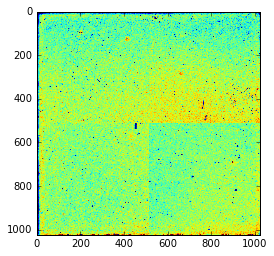

In [34]:
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(med_flat)
plt.imshow(med_flat, vmin=vmin, vmax=vmax)


In [35]:

# divide each science frame by the masterflat frame
for ii in range(0, totalframes):
    sciarray[:,:,ii] /= master_flat





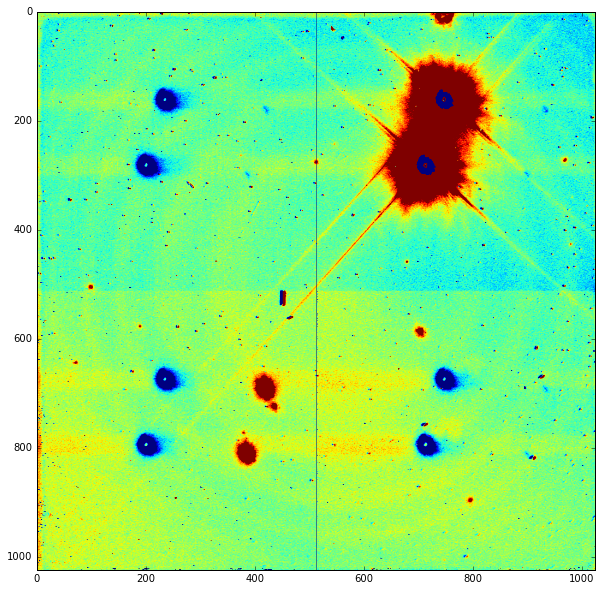

In [37]:
# show flatfielded frames:
fig = plt.figure(figsize=(10,10))
for ii in range(0, totalframes):
    vmin, vmax = interval.get_limits(sciarray[:,:,ii])
    plt.imshow(sciarray[:,:,ii], vmin=vmin, vmax=vmax)
    


In [38]:
#BAD_PIXEL_MAP

print("Creating bad pixel map and correcting for bad pixels and cosmic rays. \n",
     "This may take a moment... \n") 

# create bad pixel map
badflat = badpixelmap(med_flat, objname, flatheader)  

Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 



In [39]:

# correct the bad pixels and cosmic rays
reduced_sciarray = correct_bad_pixels(sciarray, badflat)


# some housekeeping to free memory later
#del sciarray
print(reduced_sciarray)

Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
Correcting image #{ii}
[[[1443.03414068 1413.08437549 1414.44572846 ... 1347.73943328
   1373.60513957 1388.58002216]
  [1443.03414068 1439.10147981 1453.69765837 ... 1386.17202613
   1389.92355154 1395.10017557]
  [1464.56064212 1455.46606133 1459.80797592 ... 1405.54242334
   1417.06326288 1423.92416654]
  ...
  [1489.02634881 1473.74458306 1481.7978185  ... 1442.23532306
   1445.64477777 1428.52334779]
  [1488.85952648 1473.74458306 1482.25475438 ... 1439.17367312
   1445.43592218 1428.52334779]
  [1486.45424853 1477.07657183 1489.08747129 ... 1436.83730

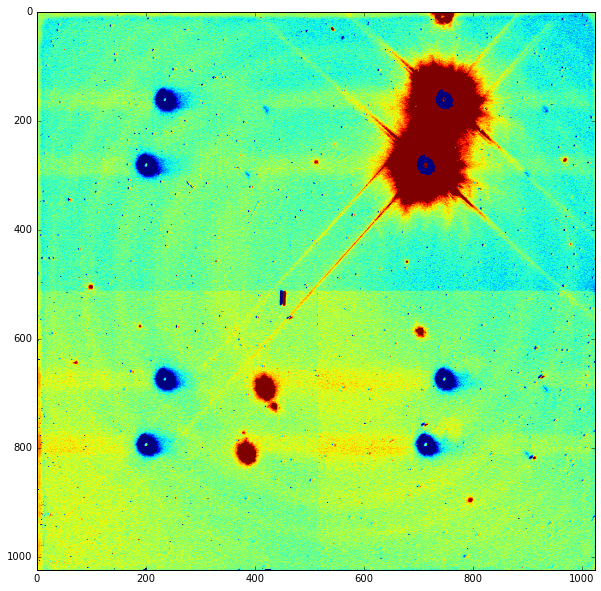

In [42]:
# show flatfielded frames:
fig = plt.figure(figsize=(10,10))
vmin, vmax = interval.get_limits(sciarray[:,:,ii])

plt.imshow(reduced_sciarray[:,:,ii], vmin=vmin, vmax=vmax)

## Sky frames!

In [43]:
#MASTER_SKY_A_AND_B

print("Creating master sky from science frames...\n") 

# create median sky from stack of science images
sky_output = create_sky_frames(reduced_sciarray, sciheader, objname, angle)

Creating master sky from science frames...



/Users/Kim/Software/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Kim/Software/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


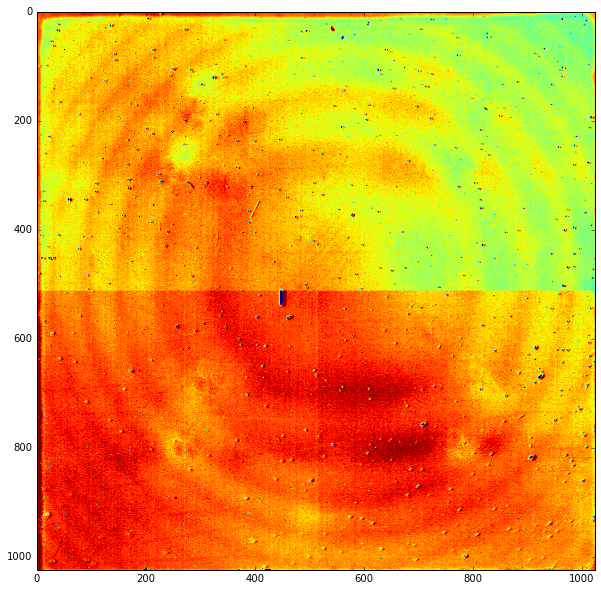

In [57]:
# show sky frame:
fig = plt.figure(figsize=(10,10))
vmin, vmax = interval.get_limits(sky_output[2])

plt.imshow(sky_output[2], vmin=vmin, vmax=vmax)